In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10  # Change this if your dataset has a different number of classes

In [ ]:

TRAIN_DIR = 'F:/2025/Lofty Agrotech Internship/processed_images/'  # Replace with path to your training images
VAL_DIR = 'F:/2025/Lofty Agrotech Internship/processed_images/'

In [ ]:
# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
# Load training and validation data
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

In [ ]:
val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

In [ ]:
# Load MobileNetV2
base_model = MobileNetV2(
    weights="imagenet",  # Pre-trained on ImageNet
    include_top=False,   # Exclude the final classification layer
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)  # Match input image size
)

In [ ]:
# Freeze the base model
base_model.trainable = False

In [ ]:
# Build the full model
model = Sequential([
    base_model,  # Add MobileNetV2 base
    GlobalAveragePooling2D(),  # Pooling layer
    Dense(256, activation="relu"),  # Fully connected layer
    Dropout(0.5),  # Regularization
    Dense(NUM_CLASSES, activation="softmax")  # Output layer for classification
])

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,  # Adjust based on dataset size
    batch_size=BATCH_SIZE
)

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

In [ ]:
# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Fine-tune the model
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    batch_size=BATCH_SIZE
)

In [44]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9457 - loss: 0.1754
Validation Accuracy: 94.50%


In [ ]:
# Save the trained model
model.save("mobilenetv2_leaf_disease_model.h5")
print("Model saved as 'mobilenetv2_leaf_disease_model.h5'")

In [ ]:

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Path to the saved model file
model_path = "mobilenetv2_leaf_disease_model.h5"  # Replace with your model file path

# Load the trained model
model = load_model(model_path)
print("Model loaded successfully!")


In [ ]:
# Prediction function
import numpy as np
import matplotlib.pyplot as plt
def predict_disease(img_path):
    # Load and preprocess the image
    img_size = IMG_SIZE
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(img_array)

    
    # Get the predicted class index
    predicted_class_idx = np.argmax(prediction, axis=-1)
    
    # Class labels (9 diseases + normal)
    class_labels = ['bacterial_leaf_blight',
'bacterial_leaf_streak',
'bacterial_panicle_blight',
'blast',
'brown_spot',
'dead_heart',
'downy_mildew',
'hispa',
'normal',
'tungro']
    # Output the result
    print(f"Predicted class: {class_labels[predicted_class_idx[0]]}")

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
# Example usage"C:\Users\Nandan\Desktop\5g"
img_path = 'C:/Users/Nandan/Desktop/intern/test_processed_images/diseased/blb.jpg'  # Replace with the actual test image path
predict_disease(img_path)

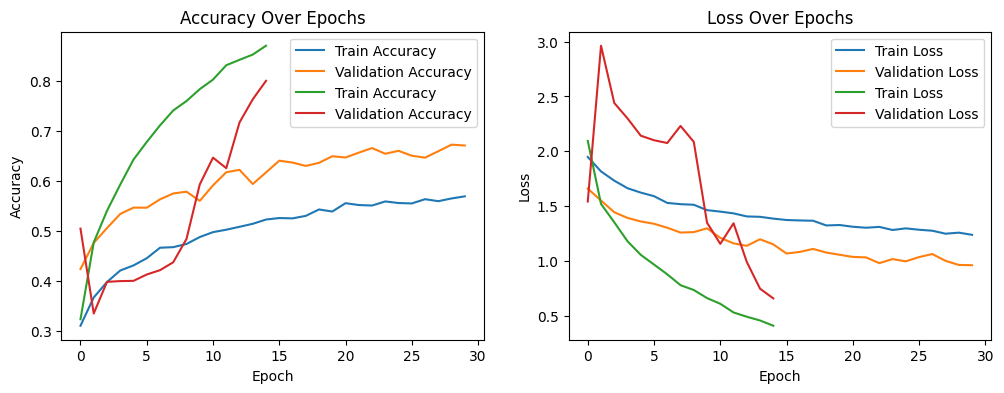

In [47]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')

plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')

plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
